In [132]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({'font.size': 14})

In [133]:
df = pd.read_excel('../data/ForeignGifts.xlsx')
df.columns = df.iloc[0]
df.set_index('ID')
df = df.iloc[1:]

In [134]:
df = df[df['Institution Name'] == 'Columbia University in the City of New York']
df['Foreign Gift Amount'] = pd.to_numeric(df['Foreign Gift Amount'])

In [135]:
# There are only two kinds of gifts
gifts = {
    'Monetary Gift': defaultdict(int),
    'Contract': defaultdict(int),
}

for _, gift in df.iterrows():
    gifts[gift['Gift Type']][gift['Country of Giftor']] += gift['Foreign Gift Amount']

countries = df['Country of Giftor'].unique()
monetary = [gifts['Monetary Gift'][country] for country in countries]
contract = [gifts['Contract'][country] for country in countries]

monetary, contract = zip(*sorted(zip(monetary, contract), key=sum))

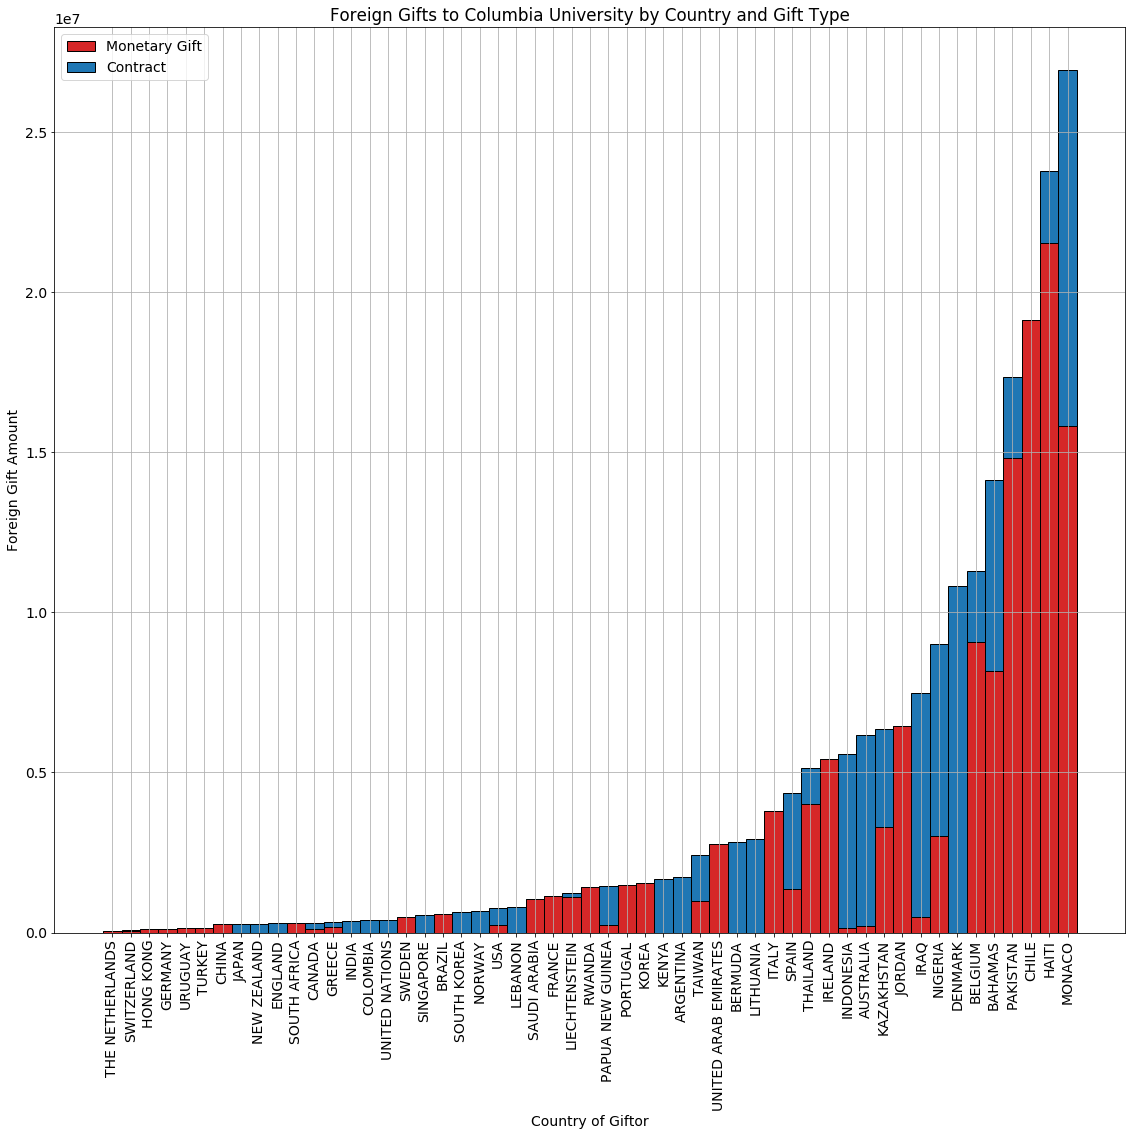

In [137]:
fig, ax = plt.subplots(figsize=(16,16))
ind = np.arange(len(df['Country of Giftor'].unique()))

width = 1
p1 = ax.bar(ind, monetary, width, color='#d62728', edgecolor='black')
p2 = ax.bar(ind, contract, width, edgecolor='black', bottom=monetary)

plt.legend((p1[0], p2[0]), ('Monetary Gift', 'Contract'))

plt.xticks(ind, list(df['Country of Giftor'].unique()))

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set(xlabel='Country of Giftor', ylabel='Foreign Gift Amount',
       title='Foreign Gifts to Columbia University by Country and Gift Type')
ax.grid()

plt.tight_layout()

plt.savefig('foreign_gifts.png')

In [144]:
cdf = df[df['Country of Giftor'] == 'MONACO']
cdf.head()

,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name
14303,14303,00270700,Columbia University in the City of New York,New York,NY,2014-05-14 00:00:00,211106,Contract,MONACO,Found Prince Albert II of Monaco
14312,14312,00270700,Columbia University in the City of New York,New York,NY,2014-04-14 00:00:00,191635,Contract,MONACO,Foundat Prince Albert II of Monaco
